In [82]:
import pandas as pd
import scipy.stats as stats
import gdown
import os
import numpy as np
from scipy.stats import shapiro  # Импортируем shapiro из scipy.stats
from scipy.stats import shapiro, levene  # Импортируем shapiro и levene из scipy.stats
from scipy.stats import mannwhitneyu  # Импортируем mannwhitneyu

In [83]:
file_id = '1BM7QmO4GoR5YxlMPfM5DLyrxBm3mn3oB'
dataset_link = f'https://drive.google.com/uc?id={file_id}'
output_file = 'after_eda_dataset.zip'

In [84]:
if not os.path.exists(output_file):
    gdown.download(dataset_link, output_file, quiet=False)
    print(f"Файл {output_file} скачан.")
else:
    print(f"Файл {output_file} уже существует.")

Файл after_eda_dataset.zip уже существует.


In [85]:
df = pd.read_csv(output_file, compression='zip')

Гипотеза: В классических партиях допускают меньшее количество ошибок и неточностей, чем в блиц-партиях.

Нулевая гипотеза (H0): "В классических и блиц-партиях нет значимой разницы в количестве ошибок."

Альтернативная гипотеза (H1): "В классических партиях допускают меньшее количество ошибок и неточностей, чем в блиц-партиях."

Обоснование выбора данной гипотезы: 

Я решила проверить данную гипотезу, чтобы убедится в том, что игроки в классических партиях имеют возможность анализировать позиции без давления времени, что способствует снижению вероятности ошибок. В то время как в блиц-партиях стресс из-за ограниченного времени может негативно сказаться на качестве принятых решений. Я хотела выяснить влияет ли время, отведенное на размышления, на качество принятых решений. 

1. Подсчет общего числа ошибок и неточностей для белых и черных игроков.

In [86]:

df['Total_Errors'] = df['White_Inaccuracy'] + df['Black_Inaccuracy'] + df['White_Mistake'] + df['Black_Mistake'] + df['White_Blunder'] + df['Black_Blunder']

2. Проверка нормальности распределения

2.1. Построение гистограммы

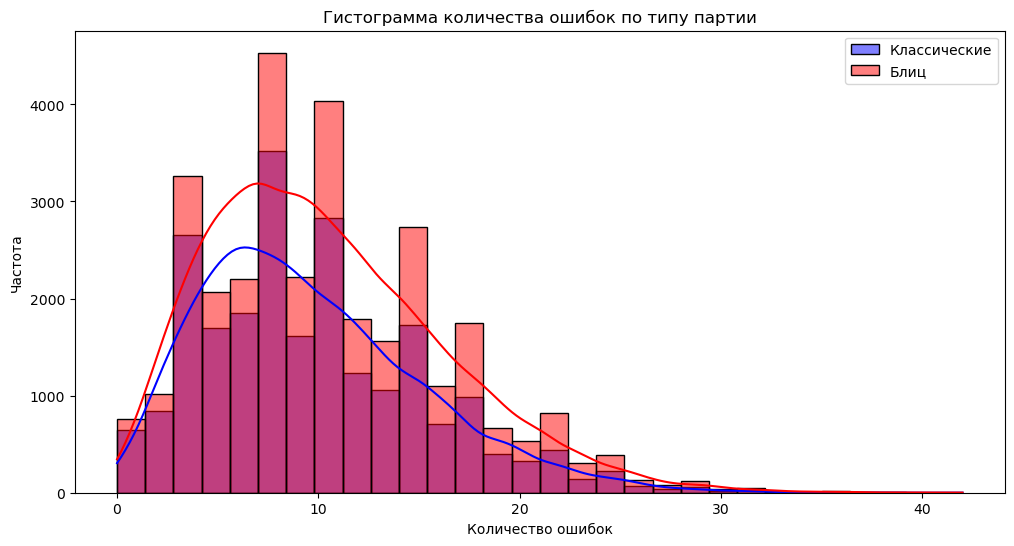

In [87]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Speed'] == 'classical']['Total_Errors'], bins=30, color='blue', label='Классические', kde=True)
sns.histplot(df[df['Speed'] == 'blitz']['Total_Errors'], bins=30, color='red', label='Блиц', kde=True)
plt.legend()
plt.title('Гистограмма количества ошибок по типу партии')
plt.xlabel('Количество ошибок')
plt.ylabel('Частота')
plt.show()

Вывод: Судя по гистограмме, распределения количества ошибок в классических партиях и блице не являются нормальными.  Они скошены вправо (правосторонняя асимметрия),  имеют более длинный "хвост" справа от пика.  Нормальное распределение симметрично относительно среднего значения.

2.2. Построение Q-Q графиков

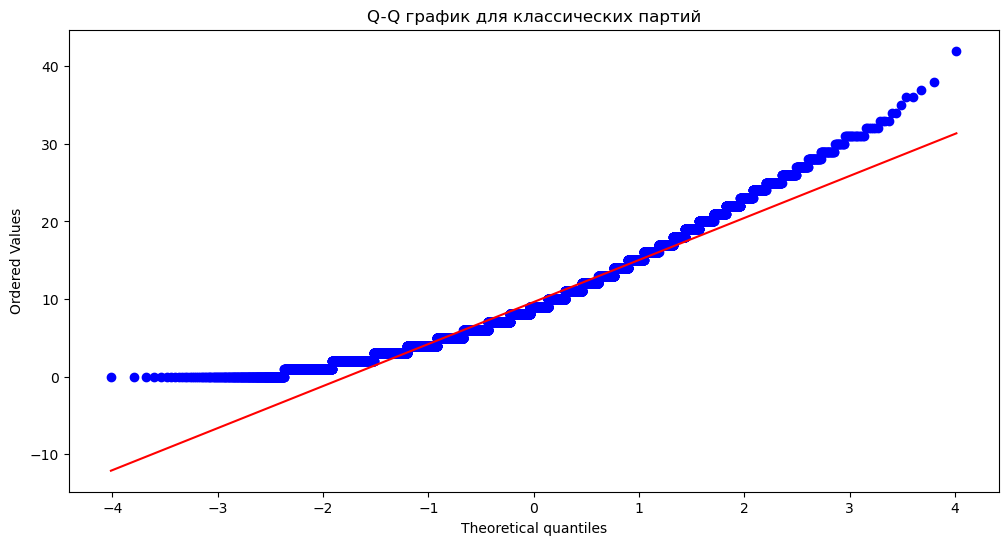

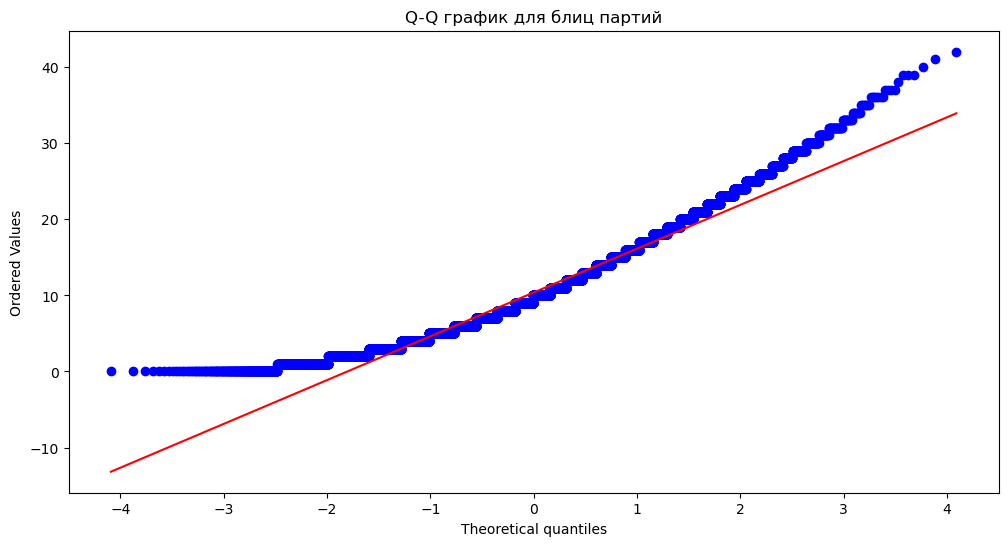

In [88]:
# Q-Q графики
plt.figure(figsize=(12, 6))
stats.probplot(df[df['Speed'] == 'classical']['Total_Errors'], dist="norm", plot=plt)
plt.title('Q-Q график для классических партий')
plt.show()

plt.figure(figsize=(12, 6))
stats.probplot(df[df['Speed'] == 'blitz']['Total_Errors'], dist="norm", plot=plt)
plt.title('Q-Q график для блиц партий')
plt.show()

Вывод: Распределения, представленные на Q-Q графиках, не является нормальными.  Отклонение синих точек от красной линии, особенно в правой части графиков, свидетельствует о наличии "тяжелого правого хвоста".  Это означает, что в данных присутствуют значения, значительно превышающие то, что ожидалось бы при нормальном распределении. Небольшое отклонение в левой части может указывать на  выбросы или асимметрию.

2.3. Тест Шапиро-Уилка

In [89]:
stat, p_value_classical = shapiro(df[df['Speed'] == 'classical']['Total_Errors'])
print('Классические партии: Статистика=%.3f, p-значение=%.3f' % (stat, p_value_classical))

stat, p_value_blitz = shapiro(df[df['Speed'] == 'blitz']['Total_Errors'])
print('Блиц партии: Статистика=%.3f, p-значение=%.3f' % (stat, p_value_blitz))

Классические партии: Статистика=0.956, p-значение=0.000
Блиц партии: Статистика=0.960, p-значение=0.000


c:\Users\Natasha\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23100.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Natasha\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32204.
  res = hypotest_fun_out(*samples, **kwds)


Вывод:оба p-значения равны 0.000, что значительно меньше стандартного уровня значимости 0.05. Это означает, что мы отвергаем нулевую гипотезу о нормальности распределения.

2.4. Тест Левена

In [90]:
stat, p_value = levene(df[df['Speed'] == 'classical']['Total_Errors'], df[df['Speed'] == 'blitz']['Total_Errors'])
print('Статистика Левена=%.3f, p-значение=%.3f' % (stat, p_value))

Статистика Левена=94.598, p-значение=0.000


Вывод:  значение 0.000 также значительно меньше 0.05, что указывает на то, что мы отвергаем нулевую гипотезу о равенстве дисперсий. Это означает, что дисперсии между классическими и блиц партиями статистически различны.

3. Выбор теста для проверки

Поскольку наши данные распределены ненормально, нам следует использовать непараметрические тесты, наиболее подходящим тестом будет тест Манна-Уитни (Mann-Whitney U test).

In [92]:
from scipy.stats import mannwhitneyu  # Импортируем mannwhitneyu

# Группировка данных по типу партии
classical_errors = df[df['Speed'] == 'classical']['Total_Errors']
blitz_errors = df[df['Speed'] == 'blitz']['Total_Errors']

# Применение теста Манна-Уитни
stat, p_value = mannwhitneyu(classical_errors, blitz_errors)

# Вывод результатов
print('Статистика Манна-Уитни=%.3f, p-значение=%.3f' % (stat, p_value))

# Интерпретация результатов
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть значимая разница в количестве ошибок.")
else:
    print("Не можем отвергнуть нулевую гипотезу: нет значимой разницы в количестве ошибок.")


Статистика Манна-Уитни=344453595.500, p-значение=0.000
Отвергаем нулевую гипотезу: есть значимая разница в количестве ошибок.


Так как наше p_value равно 0.000, а это меньше чем 0.05,
следовательно, мы отвергаем нулевую гипотезу, т.е. мы доказали, что есть значимая разница в количестве ошибок между классикой и блицом.

Таким образом наша гипотеза (в классических партиях допускают меньшее количество ошибок и неточностей, чем в блиц-партиях) верна.